In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.dpi"] = 100

In [2]:
import dateparser
import datetime

In [3]:
def clean_time(t):
    if pd.isnull(t):
        return t
    else:
        if dateparser.parse(t).time() != datetime.time(0):
            delta = datetime.datetime.now() - dateparser.parse(t)
            duration = np.ceil(delta.total_seconds()/60)
            return duration
        else:
            return np.nan

In [4]:
df_amazon = pd.read_csv('amazon.csv', index_col='id')
df_amazon.time = df_amazon.time.apply(clean_time)

In [5]:
df_rotten = pd.read_csv('rotten_tomatoes.csv', encoding='iso-8859-1', index_col='id')
df_rotten.time = df_rotten.time.apply(clean_time)
df_rotten['star'] = df_rotten[['star1', 'star2', 'star3', 'star4', 'star5', 'star6']].fillna('').apply(lambda x: ', '.join(x), axis=1)

In [6]:
df_amazon_clean = df_amazon[['time', 'director', 'star']]
df_rotten_clean = df_rotten[['time', 'director', 'star']]

In [7]:
df_train = pd.read_csv('train.csv')
df_train.columns = ['id1', 'id2', 'gold']

In [8]:
df_train = df_train.join(df_amazon_clean, on='id1')
df_train = df_train.join(df_rotten_clean, on='id2', rsuffix='_rotten')

In [9]:
df_train['f1_time'] = df_train[['time', 'time_rotten']].apply(lambda x: abs(x[0] - x[1]), axis=1)

In [10]:
# df_train['f2_director'] = df_train[['director', 'director_rotten']].apply(lambda x: x[0] == x[1], axis=1)
df_train['f2_director'] = df_train[['director', 'director_rotten']].apply(lambda x: 1 if x[0] == x[1] else 0, axis=1)

In [12]:
# df_train['f3_star'] = df_train[['star', 'star_rotten']].fillna('').apply(lambda x: set(x[0]) <= set(x[1]), axis=1)
df_train['f3_star'] = df_train[['star', 'star_rotten']].fillna('').apply(lambda x: 1 if set(x[0]) <= set(x[1]) else 0, axis=1)

In [13]:
df_train[df_train.gold==1]

,id1,id2,gold,time,director,star,time_rotten,director_rotten,star_rotten,f1_time,f2_director,f3_star
4,17,86,1,201.0,Peter Jackson,"Noel Appleby, Ali Astin",201.0,Peter Jackson,"Elijah Wood, Sean Astin, Ian McKellen, Andy Se...",0.0,1,0
7,25,4412,1,165.0,Christopher Nolan,Christian Bale,165.0,Christopher Nolan,"Christian Bale, Anne Hathaway, Tom Hardy, Mari...",0.0,1,1
15,99,3215,1,142.0,Marc Webb,"Andrew Garfield, Emma Stone",142.0,Marc Webb,"Andrew Garfield, Emma Stone, Jamie Foxx, Dane ...",0.0,1,1
17,110,3549,1,115.0,Kenneth Branagh,"Chris Hemsworth, Natalie Portman",115.0,Kenneth Branagh,"Chris Hemsworth, Natalie Portman, Anthony Hopk...",0.0,1,1
22,166,3268,1,132.0,Bryan Singer,"Hugh Jackman, James McAvoy",131.0,Bryan Singer,"Hugh Jackman, James McAvoy, Michael Fassbender...",1.0,1,1
30,184,3085,1,113.0,Alan Taylor,"Chris Hemsworth, Natalie Portman",112.0,Alan Taylor,"Chris Hemsworth, Natalie Portman, Tom Hiddlest...",1.0,1,1
31,190,2569,1,133.0,Brad Bird,"Tom Cruise, Paula Patton",132.0,Brad Bird,"Tom Cruise, Jeremy Renner, Simon Pegg, Paula P...",1.0,1,1
36,199,6390,1,211.0,Chris Columbus,Lainie Kazan,106.0,Chris Columbus,"Adam Sandler, Peter Dinklage, Kevin James, Mic...",105.0,1,0
38,228,3474,1,141.0,James Wan,"Vin Diesel, Paul Walker",140.0,James Wan,"Vin Diesel, Paul Walker, Jason Statham, Dwayne...",1.0,1,1
56,402,5683,1,141.0,Marc Webb,Andrew Garfield,142.0,Marc Webb,"Andrew Garfield, Emma Stone, Jamie Foxx, Dane ...",1.0,1,1


In [14]:
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

In [35]:
X = df_train[['f1_time', 'f2_director', 'f3_star']].as_matrix()
y = df_train['gold'].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(186, 3) (63, 3) (186,) (63,)


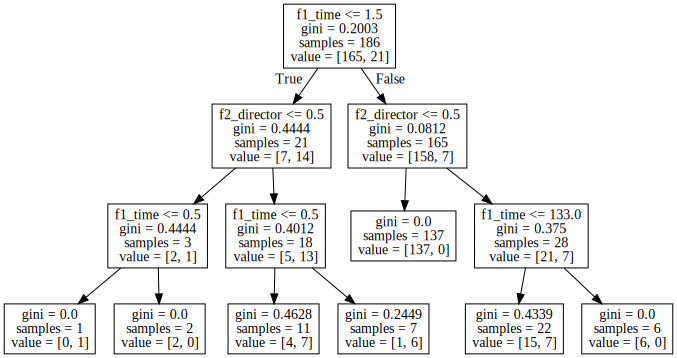

In [37]:
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# import graphviz
# X_train_imputed = Imputer().fit_transform(X_train)
# tree = DecisionTreeClassifier(max_depth=3)
# tree.fit(X_train_imputed, y_train)

# tree_dot = export_graphviz(tree, out_file=None, feature_names=['f1_time', 'f2_director', 'f3_star'])
# graphviz.Source(tree_dot)

In [38]:
# X_test_imputed = Imputer().fit_transform(X_test)
# tree.score(X_test_imputed, y_test)

0.96825396825396826

In [ ]:
# imputer needs to change 

### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
pipe_dt = make_pipeline(Imputer(), DecisionTreeClassifier())
param_grid_dt = {'decisiontreeclassifier__max_depth': range(1, 4)}
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=10)
grid_dt.fit(X_train, y_train) 

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': range(1, 4)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
grid_dt.best_params_

{'decisiontreeclassifier__max_depth': 3}

In [50]:
grid_dt.score(X_test, y_test)

0.96825396825396826

### LogisticRegression

In [52]:
from sklearn.linear_model import LogisticRegression

In [54]:
pipe_lr = make_pipeline(Imputer(), LogisticRegression())
param_grid_lr = {'logisticregression__C': np.logspace(-3, 3, 10)}
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=10)
grid_lr.fit(X_train, y_train) 

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': array([    0.001  ,     0.00464,     0.02154,     0.1    ,     0.46416,
           2.15443,    10.     ,    46.41589,   215.44347,  1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
grid_lr.best_params_

{'logisticregression__C': 0.46415888336127775}

In [56]:
grid_lr.score(X_test, y_test)

1.0

### Voting Classifier

In [64]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier([('logreg', LogisticRegression(C=0.464)),
                           ('tree', DecisionTreeClassifier(max_depth=3))],
                         voting='soft')
pipe_voting = make_pipeline(Imputer(), voting)
pipe_voting.fit(X_train, y_train)

pipe_voting.score(X_test, y_test)

0.96825396825396826